### Beschrijving Buurtscores Decision Tree TK


Maak een decision tree model op de buurten die door de expert TK is beoordeeld, met als doel om te kunnen achterhalen hoe hij zijn beslissingen heeft gemaakt. Invalshoek is hier vooral de potentie van de buurt i.t.t. expert EE die buurtaantrekkelijkheid As Is heeft bepaald. 
<br>

Gebruik makend van een basic CART uit scikit-learn.
<br>

Input: 
- buurten: bm, wm, gm aan elkaar gekoppeld (betreft alle buurten)
- buurtoordeel experts 2e ronde

Output per tree: 
- een afbeelding van de tree
- Excel met verschillen tussen voorspelling en werkelijke oordeel expert
- Excel met tree toegepast op alle buurten

### Declaraties

In [2]:
# importeren packages
import pandas as pd
import numpy as np
import seaborn as sns #visualisation
import matplotlib.pyplot as plt #visualisation

from sklearn.tree import DecisionTreeClassifier # Import Decision Tree Classifier
from sklearn.tree import DecisionTreeRegressor
from sklearn.model_selection import train_test_split # Import train_test_split function
from sklearn import metrics #Import scikit-learn metrics module for accuracy calculation

# graphviz ook apart installeren en toevoegen in path zie insructies https://stackoverflow.com/questions/45729624/graphvizs-executables-not-found-anaconda-3

from sklearn.externals.six import StringIO  
from IPython.display import Image  
from sklearn.tree import export_graphviz
import pydotplus

source_path ="Q:\\RESEARCH\\RESEARCH ALGEMEEN\\Aantrekkelijkheid buurten\\DS project 2020\\Resultaten\\"
save_path = "Q:\RESEARCH\RESEARCH ALGEMEEN\\Aantrekkelijkheid buurten\\DS project 2020\\Resultaten\\"

## Inladen data

Moet straks gemaakt worden dat het aansluit op de rest van de bestanden in de scripts, al het excel gedoe er tussenuit gooien

In [3]:
df = pd.read_excel(source_path+'buurten voor experts 2e ronde.xlsx', sheet_name='buurten')

# inlezen alle buurten waarbij de andere kolommen worden opgehaald en waardoor later het model kan worden losgelaten op alle buurten
buurten = pd.read_csv(source_path+'buurten.csv', encoding='utf-16')

## data preparatie

#### Character types

In [32]:
#df.info()
buurten.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 13624 entries, 0 to 13623
Data columns (total 58 columns):
buurtcode              13624 non-null int64
buurtnaam              13624 non-null object
buurtcodeLetters       13624 non-null object
wijkcode               13624 non-null int64
wijknaam               13624 non-null object
gemeentecode           13624 non-null int64
gemeentenaam           13624 non-null object
inw                    13624 non-null int64
bevdh                  12986 non-null float64
oadh                   13558 non-null float64
hh                     13624 non-null int64
inw65                  13624 non-null int64
KL16                   10492 non-null float64
KL18                   10546 non-null float64
VKL1618                10435 non-null float64
RLBRMTR18              10546 non-null float64
RLBWON18               10546 non-null float64
RLBBEV18               10546 non-null float64
RLBVRZ18               10546 non-null float64
RLBVEI18               10546 non-

### Samenvoegen df met oordelen en buurtinfo
dfExp: alleen beoordeelde buurten<br>
dfAlles: alle buurten

In [6]:
# df met expert oordelen: slechts 3 kolommen overhouden
keepcols = ['buurtcode', 'TK', 'EE'] 
df = df[keepcols]

# buurten: toevoegen kolom banen
buurten['banen']=(buurten['auto30']+ buurten['ov30']+buurten['fiets'])/3
# verwijderen kolommen waar we hoe dan ook niet verder mee willen gaan
delcols = ['buurtcode18', 'buurtcodeLetters18', 'buurtcodeLettersMatch', 
           'RLBRMTR16', 'RLBWON16', 'RLBBEV16', 'RLBVRZ16', 'RLBFYS16', 'RLBVEI16',
            'sleutel', 
            'wvtotaal', 'wv<1945', 'wv1945-1970', 'wv1970-1980', 'wv1980-1990', 'wv1990-2000', 'wv2000-2010', 'wv>=2010',
            'aand1945-1970', 'aand1970-1980', 'aand1980-1990', 'aand1990-2000', 'aand2000-2010','aand>=2010', 
            'ar30', 'ar60', 'door30', 'door60']
buurten = buurten.drop(delcols, axis=1)
print(buurten.head())

# aanvullen expert oordelen met info uit buurten
dfExp  = pd.merge(df, buurten, how='inner', on='buurtcode')
dfExp.replace('', np.nan, inplace=True)
# aanmaken dataframe met alle buurten en alle info excl delcols, inclusief de oordelen van TK en EE
dfAlles = pd.merge(buurten, df, how = 'left', on ='buurtcode')
dfAlles.replace('', np.nan, inplace=True)

print(dfExp.info())
print(dfAlles.info())

   buurtcode                                    buurtnaam buurtcodeLetters  \
0      30000                           Appingedam-Centrum       BU00030000   
1      30001                              Appingedam-West       BU00030001   
2      30002                              Appingedam-Oost       BU00030002   
3      30007  Verspreide huizen Damsterdiep en Eemskanaal       BU00030007   
4      30008  Verspreide huizen ten zuiden van Eemskanaal       BU00030008   

   wijkcode wijknaam  gemeentecode gemeentenaam   inw   bevdh    oadh  \
0       300  Wijk 00             3   Appingedam  2370  2812.0  1210.0   
1       300  Wijk 00             3   Appingedam  3035  1922.0   903.0   
2       300  Wijk 00             3   Appingedam  5725  2012.0  1140.0   
3       300  Wijk 00             3   Appingedam   325    60.0   359.0   
4       300  Wijk 00             3   Appingedam   100    18.0    79.0   

       ...       woxGem  woxdelta1jrGem  woxdelta5jrGem  woxwwGem  woxm2Gem  \
0      ...   

#### Dataset balanceren

Doen we nu niet maar zou eigenlijk beter zijn. We hebben te weinig data van buurtscore=c om te kunnen levelen. Dit kan wellicht in een vervolgstap gecompenseerd worden

### MaakTree method definiëren die boom maakt aan de hand van een lijst parameters en diverse output genereert
Maakt gebruik van globaal bekende: dfExp en dfAlles<br>
Retourneert: clf object<br>
Schrijft weg: 2 excels bestanden en plaatje van de tree

In [7]:
def maakTree(feature_cols, diepte, minleafsize, expert, testaandeel, random, omschrijving):
    
    # verwijderen rijen waarbij niet alle feature_cols gevuld zijn anders werkt het niet. 
    
    # Om juiste aansluiting met voorspellingen eruit te halen wordt er een nieuwe dfExp afgeleid, als ook om de oorspronkelijke
    # dfExp in tact te laten.
    dfExpNu = dfExp
    
    # toevoegen kolom expert aan feature_cols
    feature_cols.append(expert)
    dfExpNu = dfExpNu[feature_cols].dropna()
    print('Aantal rijen uit expert dataset dat gebruikt wordt: ', len(dfExpNu), 'van totaal aantal rijen: ', len(dfExp))
    # weer verwijderen van kolom export uit feature_cols
    del feature_cols[-1]
    
    # maken X en Y
    X = dfExpNu[feature_cols] # features
    y = dfExpNu[expert] # target variable TK of EE
    
    # Splits dataset in training set en test set
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=testaandeel, random_state=random)
    
    # maak decision tree classifier object
    clf = DecisionTreeClassifier(max_depth=diepte, min_samples_leaf=minleafsize)
    
    # train Decision Tree Classifiers
    clf = clf.fit(X_train,y_train)
    
    # maak met clf de voorspelling op observaties in X_test
    y_pred = clf.predict(X_test)
    
    # bereken accuracy
    accuracy = metrics.accuracy_score(y_test, y_pred)
    print('Accuracy: ', accuracy, 'bij variant: ', omschrijving)
    
    # visualisatie van tree
    dot_data = StringIO()
    export_graphviz(clf, out_file=dot_data, filled=True, rounded=True, special_characters=True, feature_names=feature_cols)
    graph = pydotplus.graph_from_dot_data(dot_data.getvalue())  
    #dit werkt niet hier: Image(graph.create_png())
    # opslaan in file werkt wel hier. Geef een herkenbare omschrijving mee zodat goed kan worden vergeleken.
    graph.write_png(save_path+'\\Bomen\\'+omschrijving+str("%.2f" % accuracy)+'.png')
    
    # de voorspellingen naast de oorspronkelijke waarden zetten.
    # y pred is een array; maak er een dataframe van
    preddf = pd.DataFrame(y_pred)
    # kolomnaam geven
    preddf.columns=['voorspeld']
    # samenvoegen X en oorspronkelijke y
    voorspeld = pd.concat([X_test, y_test], axis = 1)
    # drop index anders gaat mergen fout
    voorspeld.reset_index(drop=True, inplace=True)
    # toevoegen voorspelde Y
    voorspeld2 = pd.concat([voorspeld, preddf], axis=1)
    # selecteren en afdrukken mismatches en opslaan in XLSX
    afwijking = voorspeld2[voorspeld2[expert]!=voorspeld2['voorspeld']]
    afwijking.to_excel(save_path +'\\Bomen\\Afw'+omschrijving+str("%.2f" % accuracy)+'.xlsx')
    
    # classifier toepassen op gehele dataset. Eerst rijen met missing values uitsluiten en alleen de feature columns gebruiken. 
    # LET OP. Er wordt dus geen oordeel gegeven op rijen waarvoor dat niet mogelijk is. Dat betekent ook dat de resultaaat
    # dataset niet compleet is.
    X_alles = dfAlles[feature_cols].dropna()
    print('Aantal buurten dat een oordeel heeft gekregen: ', len(X_alles), 'van totaal: ', len(dfAlles))
    # classifier toepassen op overblijvende dataset
    allepred=clf.predict(X_alles)
    # samenvoegen. alle pred is een array, maak er een dataframe van
    allepreddf = pd.DataFrame(allepred)
    # kolomnaam geven
    allepreddf.columns=['voorspeld']
    #drop index anders gaat mergen fout
    X_alles.reset_index(drop=True, inplace=True)
    # toevoegen voorspelde Y
    voorspeldAlles = pd.concat([X_alles, allepreddf], axis=1)
    # wederom opslaan in XLSX (sorry Alex)
    voorspeldAlles.to_excel(save_path +'\\Bomen\\Alles'+omschrijving+str("%.2f" % accuracy)+'.xlsx')
    
    return clf

#### Parameters bepalen en aanroepen functie die tree maakt, verschillende varianten

Aantal rijen uit expert dataset dat gebruikt wordt:  316 van totaal aantal rijen:  338
Accuracy:  0.6947368421052632 bij variant:   d3 l20 selcols TK 
Aantal buurten dat een oordeel heeft gekregen:  6383 van totaal:  13624


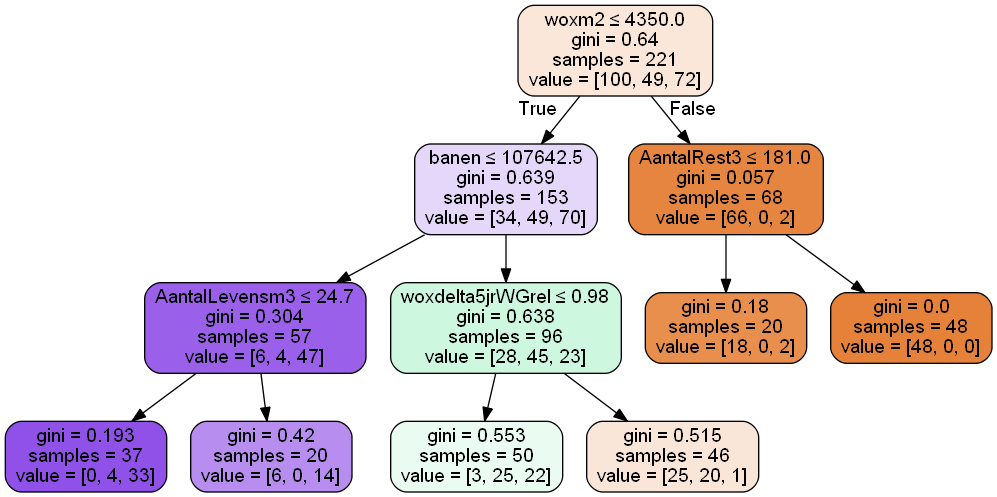

In [6]:
# max diepte 3, expert TK, beperkte selectie aan feature_cols
# resultaat: interessante boom, volledig obv WOX bij minleafsize 1, bij minleafsize 20 komt buurtcode erbij maar blijft alles A

# diepte voor max_depth: aantal nodes een integer of None
diepte=3
minleafsize = 20
# expert: TK of EE. Dit wordt ook de independent variabele. 
expert='TK'
# testaandeel: voor test_size, percentage dat gebruikt wordt voor de test. Tussen 0 en 0.5. 
# De rest wordt dan gebruikt voor de trainingset.
testaandeel = 0.3
# kandidaat kolommen. Dit kan ook alles zijn, dan wel opsommen. 
# buurtcode een vreemde eend in de bijt maar handig om later verschillen te zien bv.
feature_cols = ['buurtcode', 'oadh', 'AfstandSupermarkt', 'AantalLevensm3', 'AantalRest3', 'AantalPodiumk10', 'banen', 
               'woxww','woxdelta5jr', 'woxdelta5jrWGrel','woxm2', 'woxm2WG']
# varieer met dit getal om nieuwe splitsing te maken en daarmee ook andere resultaten
random = 1

# alleen wox kolommen:
#feature_cols = ['woxww','woxdelta5jr', 'woxdelta5jrWGrel','woxm2', 'woxm2WG']
# zonder wox kolommen:
#feature_cols = ['oadh', 'AfstandSupermarkt', 'AantalLevensm3', 'AantalRest3', 'AantalPodiumk10', 'banen']

omschrijving =' d3 l20 selcols TK '
clf=maakTree(feature_cols, diepte, minleafsize, expert, testaandeel, random, omschrijving)
# statement om Image af te drukken moet buiten de method
dot_data = StringIO()
export_graphviz(clf, out_file=dot_data, filled=True, rounded=True, special_characters=True, feature_names=feature_cols)
graph = pydotplus.graph_from_dot_data(dot_data.getvalue())  
Image(graph.create_png())

Aantal rijen uit expert dataset dat gebruikt wordt:  296 van totaal aantal rijen:  338
Accuracy:  0.7415730337078652 bij variant:   d3 l10 zonderWox TK 
Aantal buurten dat een oordeel heeft gekregen:  10441 van totaal:  13624


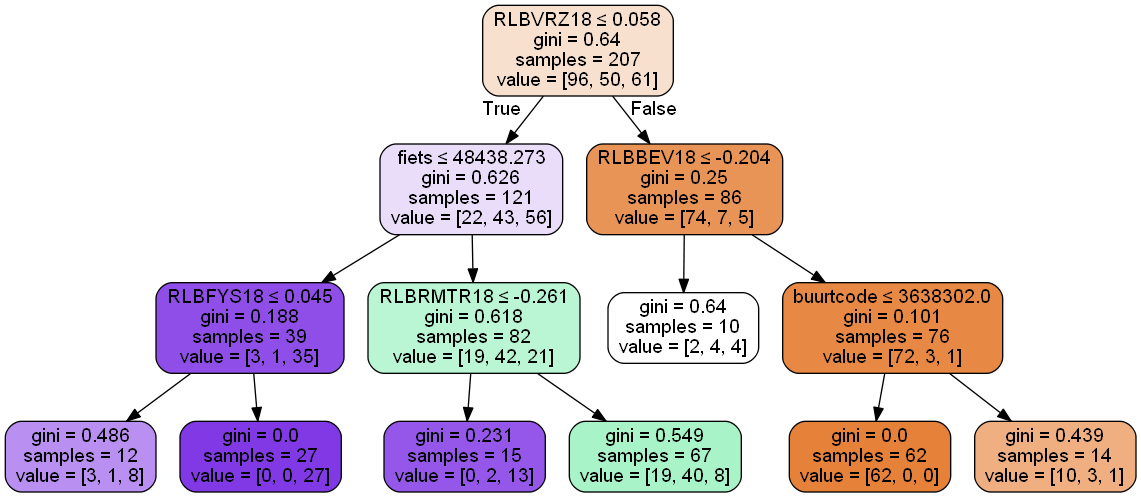

In [7]:
# TK zonder wox variabelen om de match met de totale lijst te vergroten
# resultaat: lagere accuracy en vreemde node met buurtcode en idee dat we te veel nuances missen door verwijderen wox. 
diepte=3
minleafsize=10
expert='TK'
testaandeel = 0.3
random = 2
# alle kolommen excl wox, enkele omschrijvingen, onnodige wijkcodes, marktpotentie want String, enkele variabelen die toch niet 
# bepalend zullen zijn maar wel zorgen voor verwijderen van obs. (eerst 292 vd 338 en acc 0.79 waaronder buurtcde. daarna 296 vd 338 en acc 0.77)
feature_cols = ['buurtcode','inw', 'bevdh', 'oadh', 'hh', 'inw65', 'KL18', 'RLBRMTR18', 'RLBWON18', 'RLBBEV18', 'RLBVRZ18', 'RLBVEI18', 'RLBFYS18', 
                'AfstandSupermarkt', 'AantalLevensm3', 'AfstandHuisarts', 'AantalCafe3','AantalRest3', 'AantalKinderopvang1', 
                'AfstandZwembad', 'AantalMusea10', 'AantalPodiumk10', 'AantalBios5', 
                'hh19inkLaag', 'hh19inkMidden', 'hh19inkHoog', 'aandeelMH19', 
                'auto30', 'auto60', 'ov30', 'ov60', 'fiets', 'banen'] 

omschrijving =' d3 l10 zonderWox TK '
clf=maakTree(feature_cols, diepte, minleafsize, expert, testaandeel, random, omschrijving)
# statement om Image af te drukken moet buiten de method
dot_data = StringIO()
export_graphviz(clf, out_file=dot_data, filled=True, rounded=True, special_characters=True, feature_names=feature_cols)
graph = pydotplus.graph_from_dot_data(dot_data.getvalue())  
Image(graph.create_png())

Aantal rijen uit expert dataset dat gebruikt wordt:  292 van totaal aantal rijen:  338
Accuracy:  0.8409090909090909 bij variant:   all d4 l1 TK 
Aantal buurten dat een oordeel heeft gekregen:  5621 van totaal:  13624


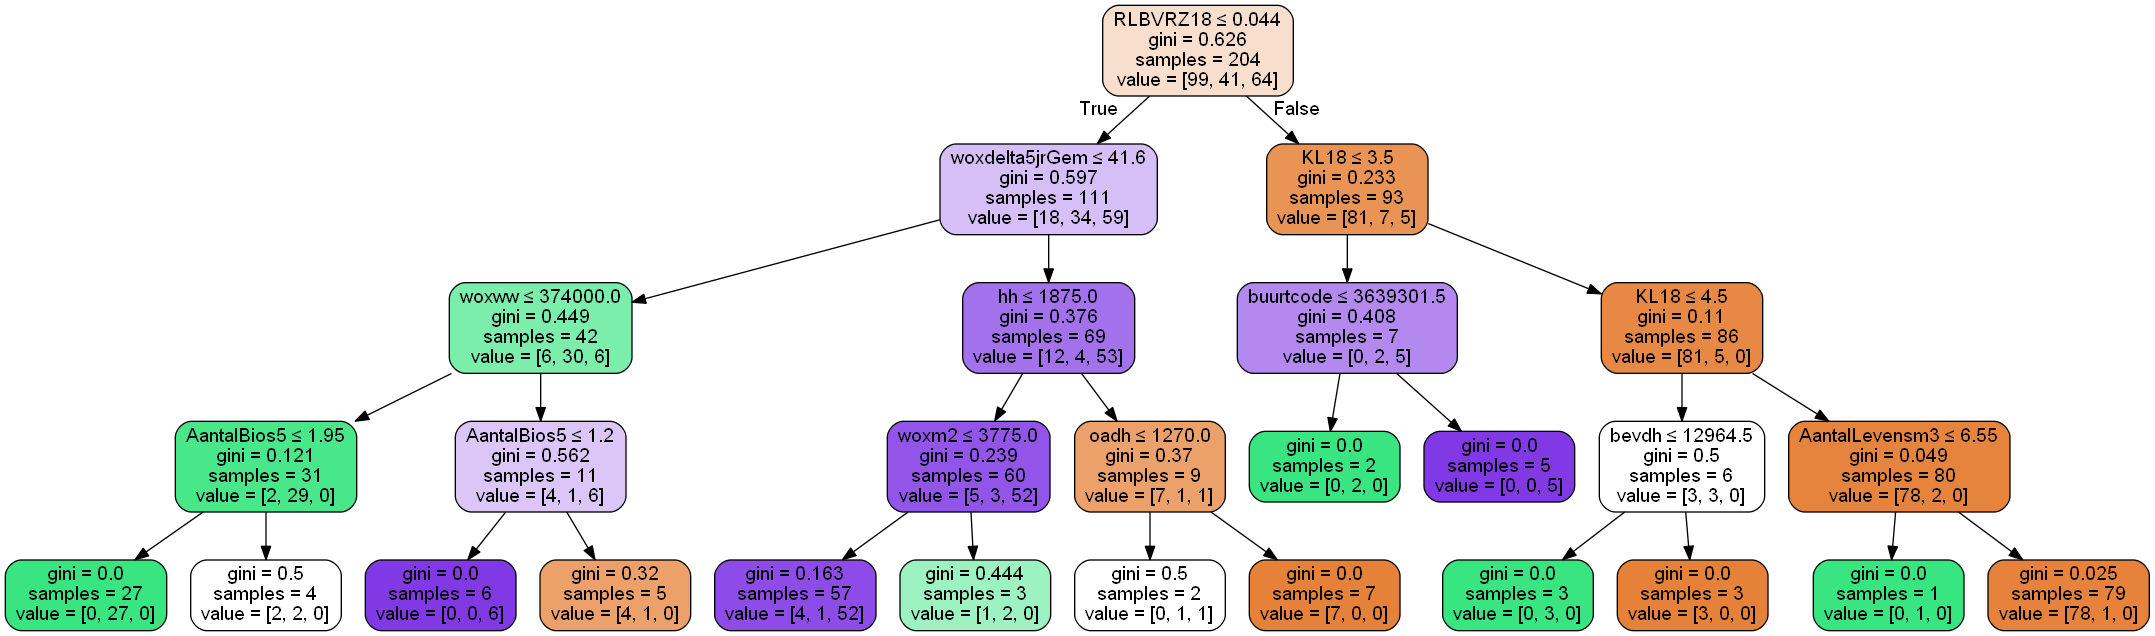

In [12]:
# TK zonder beperkingen in variabelen, max depth 4
# resultaat: accuracy erg hoog, veel variabelen omtrent voorzieningen. 
diepte=4
minleafsize=1
expert='TK'
testaandeel = 0.3
random = 1
# alle kolommen! behalve enkele omschhrijvingen, onnodige wijkcodes, marktpotentie want String 
feature_cols = ['buurtcode','inw', 'bevdh', 'oadh', 'hh', 'inw65', 'KL16', 'KL18', 'VKL1618',
                'RLBRMTR18', 'RLBWON18', 'RLBBEV18', 'RLBVRZ18', 'RLBVEI18', 'RLBFYS18', 
                'AfstandSupermarkt', 'AantalLevensm3', 'AfstandHuisarts', 'AantalCafe3','AantalRest3', 'AantalKinderopvang1', 
                'AfstandZwembad', 'AantalMusea10', 'AantalPodiumk10', 'AantalBios5', 
                'hh19inkLaag', 'hh30inkLaag', 'hh19inkMidden', 'hh30inkMidden', 'hh19inkHoog', 'hh30inkHoog', 
                'aandeelMH19', 'auto30', 'auto60', 'ov30', 'ov60', 'fiets', 
                'wox', 'woxdelta1jr', 'woxdelta5jr', 'woxww', 'woxm2', 
                'woxGem', 'woxdelta1jrGem', 'woxdelta5jrGem', 'woxwwGem', 'woxm2Gem', 'woxdelta5jrWGabs', 'woxdelta5jrWGrel', 
                'woxm2WG','banen'] 


omschrijving =' all d4 l1 TK '
clf=maakTree(feature_cols, diepte, minleafsize, expert, testaandeel, random, omschrijving)
# statement om Image af te drukken moet buiten de method
dot_data = StringIO()
export_graphviz(clf, out_file=dot_data, filled=True, rounded=True, special_characters=True, feature_names=feature_cols)
graph = pydotplus.graph_from_dot_data(dot_data.getvalue())  
Image(graph.create_png())

Aantal rijen uit expert dataset dat gebruikt wordt:  292 van totaal aantal rijen:  338
Accuracy:  0.7386363636363636 bij variant:   vol d5 l20 TK 
Aantal buurten dat een oordeel heeft gekregen:  5621 van totaal:  13624


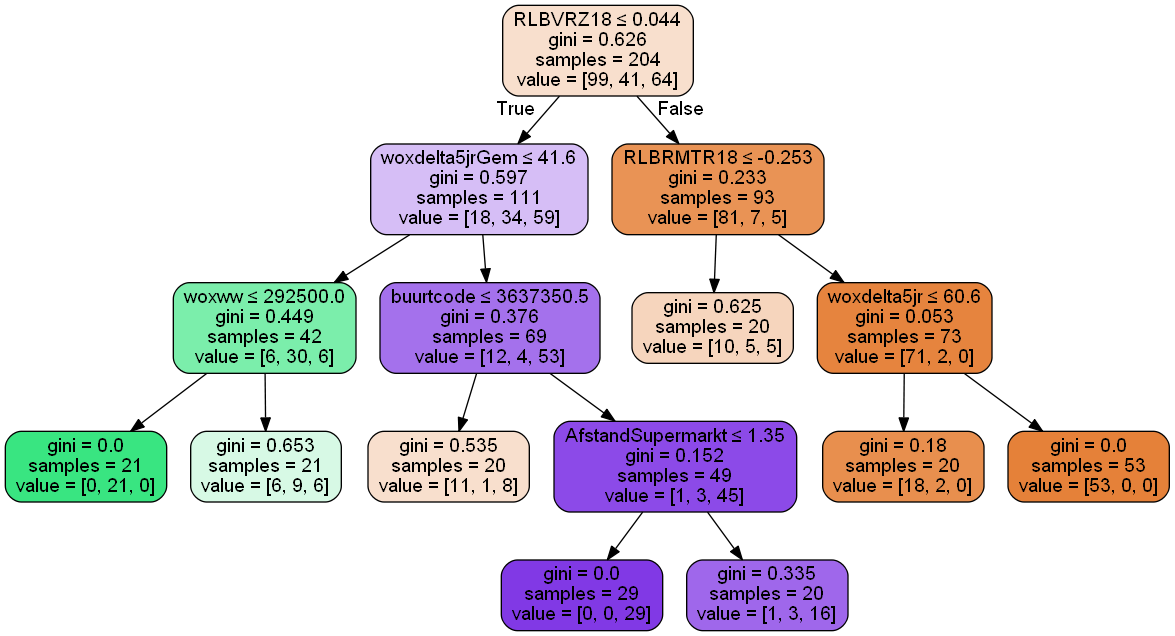

In [14]:
# TK zonder beperkingen in variabelen, max depth 5, leaf size 20
diepte=5
minleafsize=20
expert='TK'
testaandeel = 0.3
random = 1
# alle kolommen! behalve enkele omschrijvingen, onnodige wijkcodes, marktpotentie want String 
feature_cols = ['buurtcode','inw', 'bevdh', 'oadh', 'hh', 'inw65', 'KL16', 'KL18', 'VKL1618',
                'RLBRMTR18', 'RLBWON18', 'RLBBEV18', 'RLBVRZ18', 'RLBVEI18', 'RLBFYS18', 
                'AfstandSupermarkt', 'AantalLevensm3', 'AfstandHuisarts', 'AantalCafe3','AantalRest3', 'AantalKinderopvang1', 
                'AfstandZwembad', 'AantalMusea10', 'AantalPodiumk10', 'AantalBios5', 
                'hh19inkLaag', 'hh30inkLaag', 'hh19inkMidden', 'hh30inkMidden', 'hh19inkHoog', 'hh30inkHoog', 
                'aandeelMH19', 'auto30', 'auto60', 'ov30', 'ov60', 'fiets', 
                'wox', 'woxdelta1jr', 'woxdelta5jr', 'woxww', 'woxm2', 
                'woxGem', 'woxdelta1jrGem', 'woxdelta5jrGem', 'woxwwGem', 'woxm2Gem', 'woxdelta5jrWGabs', 'woxdelta5jrWGrel', 
                'woxm2WG','banen'] 


omschrijving =' vol d5 l20 TK '
clf=maakTree(feature_cols, diepte, minleafsize, expert, testaandeel, random, omschrijving)
# statement om Image af te drukken moet buiten de method
dot_data = StringIO()
export_graphviz(clf, out_file=dot_data, filled=True, rounded=True, special_characters=True, feature_names=feature_cols)
graph = pydotplus.graph_from_dot_data(dot_data.getvalue())  
Image(graph.create_png())

Aantal rijen uit expert dataset dat gebruikt wordt:  292 van totaal aantal rijen:  338
Accuracy:  0.7727272727272727 bij variant:   all d3 l20 TK 
Aantal buurten dat een oordeel heeft gekregen:  5621 van totaal:  13624


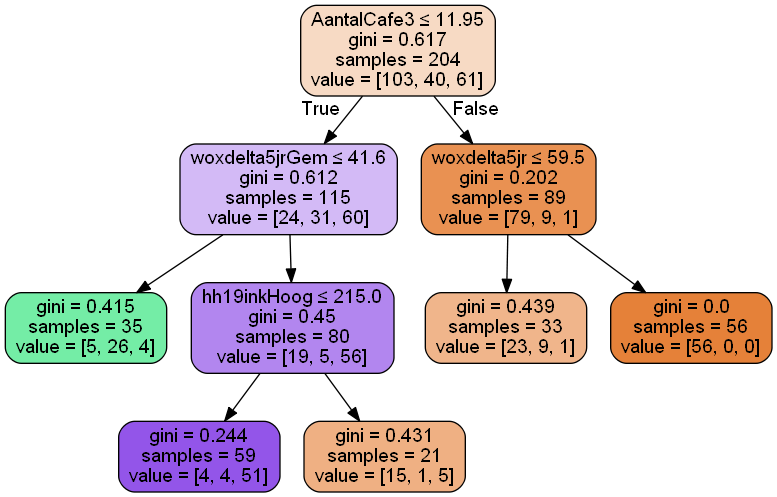

In [15]:
# TK zonder beperkingen in variabelen, max depth 3
diepte=3
minleafsize=20
expert='TK'
testaandeel = 0.3
random = 2
# alle kolommen! behalve enkele omschhrijvingen, onnodige wijkcodes, marktpotentie want String 
feature_cols = ['buurtcode','inw', 'bevdh', 'oadh', 'hh', 'inw65', 'KL16', 'KL18', 'VKL1618',
                'RLBRMTR18', 'RLBWON18', 'RLBBEV18', 'RLBVRZ18', 'RLBVEI18', 'RLBFYS18', 
                'AfstandSupermarkt', 'AantalLevensm3', 'AfstandHuisarts', 'AantalCafe3','AantalRest3', 'AantalKinderopvang1', 
                'AfstandZwembad', 'AantalMusea10', 'AantalPodiumk10', 'AantalBios5', 
                'hh19inkLaag', 'hh30inkLaag', 'hh19inkMidden', 'hh30inkMidden', 'hh19inkHoog', 'hh30inkHoog', 
                'aandeelMH19', 'auto30', 'auto60', 'ov30', 'ov60', 'fiets', 
                'wox', 'woxdelta1jr', 'woxdelta5jr', 'woxww', 'woxm2', 
                'woxGem', 'woxdelta1jrGem', 'woxdelta5jrGem', 'woxwwGem', 'woxm2Gem', 'woxdelta5jrWGabs', 'woxdelta5jrWGrel', 
                'woxm2WG','banen'] 

omschrijving =' all d3 l20 TK '
clf=maakTree(feature_cols, diepte, minleafsize, expert, testaandeel, random, omschrijving)
# statement om Image af te drukken moet buiten de method
dot_data = StringIO()
export_graphviz(clf, out_file=dot_data, filled=True, rounded=True, special_characters=True, feature_names=feature_cols)
graph = pydotplus.graph_from_dot_data(dot_data.getvalue())  
Image(graph.create_png())

Aantal rijen uit expert dataset dat gebruikt wordt:  300 van totaal aantal rijen:  338
Accuracy:  0.8888888888888888 bij variant:   d4 l5 sel TK 6 
Aantal buurten dat een oordeel heeft gekregen:  5724 van totaal:  13624


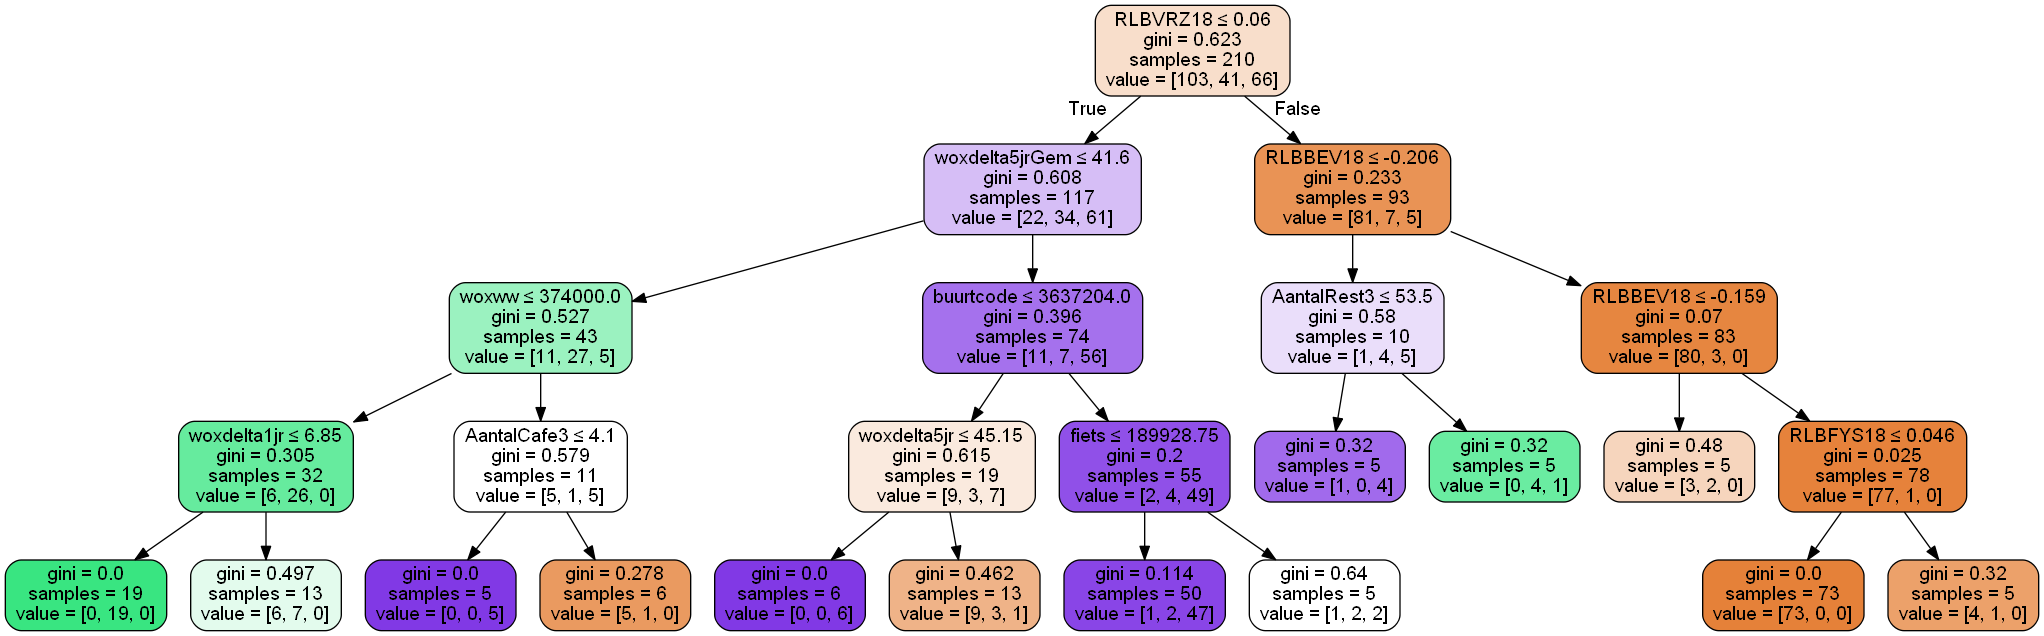

In [22]:
# TK met een weloverwogen selectie aan feature columns
# of AantalCafe3 is root node, of RLBVRZ18. die tweede vaak wat hogere accuracy. Ga verder met random 6
diepte=4
minleafsize=5
expert='TK'
testaandeel = 0.3
random = 6
# alle kolommen! behalve enkele omschhrijvingen, onnodige wijkcodes, marktpotentie want String 
feature_cols = ['buurtcode', 'bevdh', 'oadh', 
                'KL18', 'RLBRMTR18', 'RLBWON18', 'RLBBEV18', 'RLBVRZ18', 'RLBVEI18', 'RLBFYS18', 
                'AfstandSupermarkt', 'AantalLevensm3','AantalCafe3', 'AantalRest3', 'AantalBios5',
                'auto30', 'ov30', 'fiets', 'banen',
                'wox', 'woxdelta1jr', 'woxdelta5jr', 'woxdelta5jrGem', 'woxww', 'woxm2', 
                'woxdelta5jrWGrel', 'woxm2WG'] 


omschrijving =' d4 l5 sel TK 6 '
clf=maakTree(feature_cols, diepte, minleafsize, expert, testaandeel, random, omschrijving)
# statement om Image af te drukken moet buiten de method
dot_data = StringIO()
export_graphviz(clf, out_file=dot_data, filled=True, rounded=True, special_characters=True, feature_names=feature_cols)
graph = pydotplus.graph_from_dot_data(dot_data.getvalue())  
Image(graph.create_png())

In [23]:
# clf die het is geworden wederom toepassen op gehele dataset. 
# Eerst rijen met missing values uitsluiten en alleen de feature columns gebruiken. 
# LET OP. Er wordt dus geen oordeel gegeven op rijen waarvoor dat niet mogelijk is. Dat betekent ook dat de resultaaat
# dataset niet compleet is.
X_alles = dfAlles[feature_cols].dropna()
print('Aantal buurten dat een oordeel heeft gekregen: ', len(X_alles), 'van totaal: ', len(dfAlles))
# classifier toepassen op overblijvende dataset
allepred=clf.predict(X_alles)
# samenvoegen. alle pred is een array, maak er een dataframe van
allepreddf = pd.DataFrame(allepred)
# kolomnaam geven
allepreddf.columns=['voorspeld']
#drop index anders gaat mergen fout
X_alles.reset_index(drop=True, inplace=True)
# toevoegen voorspelde Y
voorspeldAlles = pd.concat([X_alles, allepreddf], axis=1)

Aantal buurten dat een oordeel heeft gekregen:  5724 van totaal:  13624


In [31]:
## decision tree nabootsen met if then statements en iets rondere grenzen
grenslbvrz = 0.06
grenslbbev = -0.206
grenscafe = 11
grensgem5j = 41
grenswoxww = 375000
grensoadh = 600

# voorspeldAlles mee door gaan. Dit zijn de buurten die door de clf een oordeel hebben kunnen krijgen.
df = voorspeldAlles

# 6 nieuwe kolommen obv deze 6 grenzen
df['lbvrz'] = np.where(df['RLBVRZ18'] <= grenslbvrz, 'weinigvoorz', 'veelvoorz' )
df['lbbev'] = np.where(df['RLBBEV18'] <= grenslbbev, 'slecht', 'goed')
df['cafe'] = np.where(df['AantalCafe3'] <= grenscafe, 'weinigcafe', 'veelcafe')
df['gem5j'] = np.where(df['woxdelta5jrGem'] <= grensgem5j, 'langzaam', 'snel')
df['ww'] = np.where(df['woxww']<= grenswoxww, 'goedkoop', 'duur')
df['dh'] = np.where(df['oadh'] <= grensoadh, 'dun', 'dicht')

# elke verschillende route afleiden
df['A'] = np.where((df['lbvrz'] == 'veelvoorz'), 'A', np.where((df['lbvrz'] == 'weinigvoorz')   & (df['gem5j'] == 'langzaam') & (df['ww'] == 'duur') & (df['dh'] == 'dicht'), 'A', ''))
df['B'] = np.where((df['lbvrz'] == 'weinigvoorz')  & (df['gem5j'] == 'langzaam') & (df['ww'] == 'goedkoop'), 'B', '')
df['oordeel'] = np.where((df['A'] == 'A'), 'A', np.where((df['B'] == 'B'), 'B', 'C'))

# vergelijk met clf uitkomst
afwijking = df[df['voorspeld'].str.upper()  != df['oordeel']]
print(afwijking[['buurtcode', 'RLBVRZ18', 'RLBBEV18', 'RLBVRZ18', 'woxdelta5jrGem', 'woxww', 'oadh', 'AantalCafe3', 'lbvrz', 'lbbev', 'cafe', 'gem5j', 'ww', 'dh', 'voorspeld', 'oordeel']].head())
print('aantal afwijkingen: ', len(afwijking))

# afwijkingen komen voor 487 gevallen door buurtcode tak, niet door ronde grenzen, en voor 50 gevallen door rondere grenzen
df.to_excel(save_path +'\\Bomen\\df resultaat TK.xlsx')

    buurtcode  RLBVRZ18  RLBBEV18  RLBVRZ18  woxdelta5jrGem     woxww    oadh  \
85     340202  0.040410 -0.110189  0.040410            45.6  275000.0  1509.0   
86     340203 -0.004631 -0.160974 -0.004631            45.6  275000.0  1650.0   
87     340204  0.031814 -0.082522  0.031814            45.6  275000.0  2075.0   
88     340205  0.036534 -0.108853  0.036534            45.6  275000.0  1729.0   
89     340206  0.034495 -0.053097  0.034495            45.6  275000.0  1188.0   

    AantalCafe3        lbvrz lbbev        cafe gem5j        ww     dh  \
85         15.9  weinigvoorz  goed    veelcafe  snel  goedkoop  dicht   
86          1.1  weinigvoorz  goed  weinigcafe  snel  goedkoop  dicht   
87         14.9  weinigvoorz  goed    veelcafe  snel  goedkoop  dicht   
88         17.4  weinigvoorz  goed    veelcafe  snel  goedkoop  dicht   
89         16.7  weinigvoorz  goed    veelcafe  snel  goedkoop  dicht   

   voorspeld oordeel  
85         a       C  
86         a       C  
87   

### Decision tree voor de buurten zonder WOX kolommen
Kan gebaseerd op alle buurten, maar zal worden toegepast op alleen buurten zonder WOX kolommen


Aantal rijen uit expert dataset dat gebruikt wordt:  292 van totaal aantal rijen:  338
Accuracy:  0.7613636363636364 bij variant:   noWOX d4 l10 r6 TK 
Aantal buurten dat een oordeel heeft gekregen:  10323 van totaal:  13624


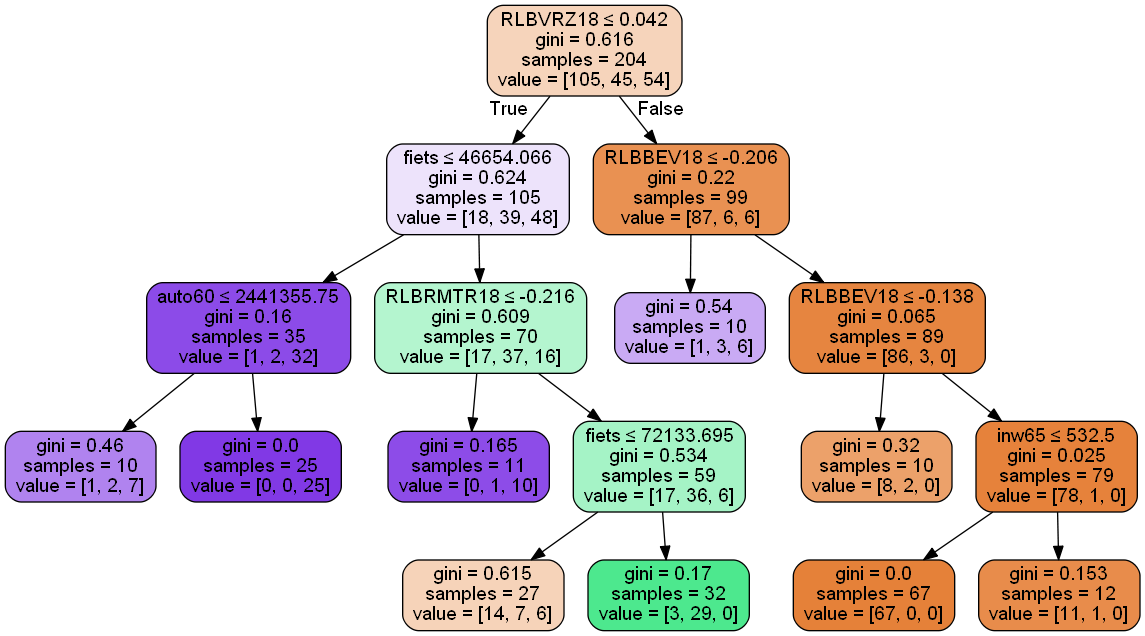

In [10]:
# no Wox. buurtcode komt nog hoger dan incl WOX. en accuracy iets lager rond 0.75. AantalCafe3 en RLBRZ18 blijft vaak als root node voorkomen.
diepte=4
minleafsize=10
expert='TK'
testaandeel = 0.3
random = 6
'''# weloverwogen selectie sowieso zonder WOX
feature_cols = ['buurtcode', 'inw', 'bevdh', 'oadh', 'hh', 'KL18',
                'RLBRMTR18', 'RLBWON18', 'RLBBEV18', 'RLBVRZ18', 'RLBVEI18', 'RLBFYS18', 
              'AfstandSupermarkt', 'AantalLevensm3', 'AfstandHuisarts', 'AantalCafe3','AantalRest3', 'AantalKinderopvang1', 
                'AfstandZwembad', 'AantalMusea10',  'AantalPodiumk10', 'AantalBios5', 
               'aandeelMH19', 'auto30', 'ov30', 'fiets','banen'] 
               '''
#alles excl WOX
feature_cols = ['buurtcode','inw', 'bevdh', 'oadh', 'hh', 'inw65', 'KL16', 'KL18', 'VKL1618',
                'RLBRMTR18', 'RLBWON18', 'RLBBEV18', 'RLBVRZ18', 'RLBVEI18', 'RLBFYS18', 
              'AfstandSupermarkt', 'AantalLevensm3', 'AfstandHuisarts', 'AantalCafe3','AantalRest3', 'AantalKinderopvang1', 
                'AfstandZwembad', 'AantalMusea10',  'AantalPodiumk10', 'AantalBios5', 
                'hh19inkLaag', 'hh30inkLaag', 'hh19inkMidden', 'hh30inkMidden', 'hh19inkHoog', 'hh30inkHoog', 
             'aandeelMH19', 'auto30', 'auto60', 'ov30', 'ov60', 'fiets','banen'] 

omschrijving =' noWOX d4 l10 r6 TK '
clf=maakTree(feature_cols, diepte, minleafsize, expert, testaandeel, random, omschrijving)
# statement om Image af te drukken moet buiten de method
dot_data = StringIO()
export_graphviz(clf, out_file=dot_data, filled=True, rounded=True, special_characters=True, feature_names=feature_cols)
graph = pydotplus.graph_from_dot_data(dot_data.getvalue())  
Image(graph.create_png())

In [11]:
# clf die het is geworden d4 l10 r6; wederom toepassen op gehele dataset. 
# Eerst rijen met missing values uitsluiten en alleen de feature columns gebruiken. 
# LET OP. Er wordt dus geen oordeel gegeven op rijen waarvoor dat niet mogelijk is. Dat betekent ook dat de resultaaat
# dataset niet compleet is.
X_alles = dfAlles[feature_cols].dropna()
print('Aantal buurten dat een oordeel heeft gekregen: ', len(X_alles), 'van totaal: ', len(dfAlles))
# classifier toepassen op overblijvende dataset
allepred=clf.predict(X_alles)
# samenvoegen. alle pred is een array, maak er een dataframe van
allepreddf = pd.DataFrame(allepred)
# kolomnaam geven
allepreddf.columns=['voorspeld']
#drop index anders gaat mergen fout
X_alles.reset_index(drop=True, inplace=True)
# toevoegen voorspelde Y
voorspeldAlles = pd.concat([X_alles, allepreddf], axis=1)

Aantal buurten dat een oordeel heeft gekregen:  10323 van totaal:  13624


In [21]:
## decision tree nabootsen met if then statements
grenslbvrz = 0.042
grenslbbev = -0.206
grenslb = -0.216
grensfiets = 47000

# voorspeldAlles mee door gaan. Dit zijn de buurten die door de clf een oordeel hebben kunnen krijgen.
df = voorspeldAlles

# 4 nieuwe kolommen obv de 5 grenzen
df['lbvrz'] = np.where(df['RLBVRZ18']<=grenslbvrz, 'slecht', 'goed')
df['lbbev'] = np.where(df['RLBBEV18'] <= grenslbbev, 'slecht', 'goed')
df['lb'] = np.where(df['RLBRMTR18'] <= grenslb, 'slecht', 'goed')
df['fietsbanen'] = np.where(df['fiets']<grensfiets, 'weinig', 'veel')

# afleiden oordeel
df['oordeel'] = np.where((df['lbvrz'] == 'goed'), np.where(df['lbbev'] == 'goed', 'A', 'C'),
                         np.where(df['fietsbanen']=='veel', np.where(df['lb'] == 'goed', 'B', 'C'), 'C'))
                                                                        
# vergelijk met clf uitkomst
afwijking = df[df['voorspeld'].str.upper()  != df['oordeel']]
print(afwijking[['buurtcode','RLBVRZ18', 'RLBBEV18', 'RLBRMTR18', 'fiets', 'lbvrz', 'lbbev', 'lb', 'fietsbanen', 'voorspeld', 'oordeel']].head())
print('aantal afwijkingen tov voorspelling ', len(afwijking))

df.to_excel(save_path +'\\Bomen\\df TK zonder wox resultaat.xlsx')

     buurtcode  RLBVRZ18  RLBBEV18  RLBRMTR18          fiets   lbvrz lbbev  \
46      140701  0.042002  0.032598   0.156231  145681.875000    goed  goed   
83      141701  0.005823  0.048715   0.123818   60394.454545  slecht  goed   
84      141702 -0.018581  0.090404   0.467365   48545.500000  slecht  goed   
85      141703 -0.053783  0.070653   0.411297   54058.666667  slecht  goed   
111     340101  0.028871 -0.082154  -0.161113   61463.900000  slecht  goed   

       lb fietsbanen voorspeld oordeel  
46   goed       veel         b       A  
83   goed       veel         a       B  
84   goed       veel         a       B  
85   goed       veel         a       B  
111  goed       veel         a       B  
aantal afwijkingen tov voorspelling  1023
